In [3716]:
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

load_dotenv()


True

Carrier colors dictionary:

In [3717]:
carrier_color_dict = {
                        'Verizon': '#b00000',
                        'AT&T': '#067ab4',
                        'T-Mobile': '#e60076',
                        'Sprint': '#ffaa00',
                        'Dish': '#3F3F3F',
                        'EE': '#2e9b9d',
                        'O2': '#010066',
                        'Three': '#000000',
                        'Vodafone': '#f80000',
                        'O2 UK': '#010066',
                        'Three UK': '#000000',
                        'Vodafone UK': '#f80000',
                        'Sunrise': '#d0606f',
                        'Swisscom': '#5b92cc',
                        'Salt': '#56bf83',
                        'ODIDO': '#FF7621',
                        'KPN': '#FFBB00',
                        'Vodafone NL': '#f80000',
                        'KT': '#FF7621',
                        'SK Telecom': '#FFBB00',
                        'LG U+': '#f80000'
                     }

In [3718]:
carrier_color_dict_reporting = {
                                'Salt': '#1A1A1A',
                                'Sunrise': '#E6003C',
                                'Swisscom': '#001155',
                                'AT&T': '#008FCC',
                                'Sprint': '#FFAA00',
                                'T-Mobile': '#E60076',
                                'Verizon': '#B00000',
                                'EE': '#1D9F9E',
                                'O2': '#010066',
                                'Three': '#070707',
                                'Vodafone': '#F80000',
                                'KT': '#FF3333',
                                'LG U+': '#CC0066',
                                'SK Telecom': '#FF9933',
                                'Dish': '#F87217'
                            }

Network type colors dictionary:

In [3719]:
dl_color_dict = {
  '5G': '#009697', 
  'Mixed-5G': '#3CB371', 
  'LTE': '#58595b',
  'Non-LTE': '#f4a460'
}

Metadata test summary by CSDI

In [3720]:
curr_csid = 12705
# curr_csid = 12655

In [3721]:
ts_curr = f'''
SELECT
   date_trunc('seconds',ts.start_time)::timestamp without time zone as start_time,
   ca.time_zone,
   vcs.collection_type,
   vcs.collection_set,
   ts.collection_set_id,
   ts.test_type_id,
   c.friendly_name AS carrier,
   ts.net_types,
   ts.call_network_type, -- Note: Substitute for `co_call_network_type`
   ts.flag_access_success,
   ts.flag_task_success,
   ts.dsd_effective_download_test_speed,
   ts.dsd_throughput_max,
   ts.dsu_effective_upload_test_speed,
   ts.percentage_access_success,
   ts.percentage_task_success,
   md2.fn_get_best_network_type(ts.test_type_id, 
                                          ts.net_types, 
                                          tea.network_types, 
                                          tea.call_network_type, 
                                          tea.nr_status_filtered, 
                                          tea.nr_bearer_status_filtered,
                                          tea.nr_bearer_allocation_status_filtered,
                                          ',') AS best_network_type,
   md2.fn_get_network_types(ts.net_types, ','::character varying) AS net_types_desc,
   kt.name AS kit_type,
   rsc.name AS report_set_collector,
   (ts.start_time AT TIME ZONE 'utc' AT TIME ZONE ca.time_zone) AS local_time
FROM prod_ms_partitions.test_summary_{curr_csid} as ts
LEFT JOIN md2.collection_areas ca on (ts.collection_area_id = ca.collection_area_id)
LEFT JOIN md2.vi_collection_sets vcs on (ts.collection_set_id = vcs.collection_set_id)
LEFT JOIN md2.carriers c on (ts.carrier_id = c.carrier_id)
LEFT JOIN prod_rsr_partitions.test_event_aggr_{curr_csid} tea on (ts.collection_set_id = tea.collection_set_id and ts.test_event_id = tea.test_event_id)
LEFT JOIN md2.kit_types kt on (kt.kit_type_id = ts.kit_type_id)
LEFT JOIN md2.report_set_collectors rsc on (rsc.report_set_collector_id = ts.report_set_collector_id)
WHERE ts.test_type_id IN (19, 20, 23) 
AND ts.collection_set_period_id IS NOT NULL 
AND ts.blacklisted = FALSE 
AND ts.flag_valid = TRUE 
AND ts.carrier_id <> 478
'''

df_ts_curr  = pd.read_sql_query(ts_curr, con=os.getenv('RSR_SVC_CONN'))

df_ts_curr.head()

,start_time,time_zone,collection_type,collection_set,collection_set_id,test_type_id,carrier,net_types,call_network_type,flag_access_success,flag_task_success,dsd_effective_download_test_speed,dsd_throughput_max,dsu_effective_upload_test_speed,percentage_access_success,percentage_task_success,best_network_type,net_types_desc,kit_type,report_set_collector,local_time
0,2025-01-23 20:47:35,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,19,Verizon,4194304,None,None,None,NaN,NaN,22785.791801,1.0,1.0,NR SA,NR,Car,Galaxy S24,2025-01-23 14:47:35.003
1,2025-01-23 20:43:45,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,20,AT&T,262144,None,None,None,894527.575691,1043997.808,NaN,1.0,1.0,NR NSA,LTE,Scout,Galaxy S24,2025-01-23 14:43:45.004
2,2025-01-23 20:48:40,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,19,T-Mobile,4194304,None,None,None,NaN,NaN,16984.746667,1.0,1.0,NR SA,NR,Scout,Galaxy S24,2025-01-23 14:48:40.003
3,2025-01-23 20:47:10,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,20,T-Mobile,4194304,None,None,None,275786.215175,637215.168,NaN,1.0,1.0,NR SA,NR,Car,Galaxy S24,2025-01-23 14:47:10.003
4,2025-01-23 20:43:45,America/Chicago,RSR US Metro,CorpusChristi-TX_2025-1H,12705,20,T-Mobile,4194304,None,None,None,626651.829473,780802.880,NaN,1.0,1.0,NR SA,NR,Scout,Galaxy S24,2025-01-23 14:43:45.003


Metadata test summary by COMP

In [3722]:
comp_csid = 12381
# comp_csid = 12331

In [3723]:
ts_comp = f'''
SELECT
   ts.start_time,
   ca.time_zone,
   vcs.collection_type,
   vcs.collection_set,
   ts.collection_set_id,
   ts.test_type_id,
   c.friendly_name as carrier,
   ts.net_types,
   ts.call_network_type, -- Note: Substitute for `co_call_network_type`
   ts.flag_access_success,
   ts.flag_task_success,
   ts.dsd_effective_download_test_speed,
   ts.dsd_throughput_max,
   ts.dsu_effective_upload_test_speed,
   ts.percentage_access_success,
   ts.percentage_task_success,
   md2.fn_get_best_network_type(ts.test_type_id, 
                                          ts.net_types, 
                                          tea.network_types, 
                                          tea.call_network_type, 
                                          tea.nr_status_filtered, 
                                          tea.nr_bearer_status_filtered,
                                          tea.nr_bearer_allocation_status_filtered,
                                          ','
                                          ) best_network_type,
   md2.fn_get_network_types(ts.net_types, ','::character varying) AS net_types_desc,
   kt.name AS kit_type,
   rsc.name as report_set_collector,
   (start_time at time zone 'utc' at time zone ca.time_zone) as local_time
FROM prod_ms_partitions.test_summary_{comp_csid} ts
LEFT JOIN md2.collection_areas ca on (ts.collection_area_id = ca.collection_area_id)
LEFT JOIN md2.vi_collection_sets vcs on (ts.collection_set_id = vcs.collection_set_id)
LEFT JOIN md2.carriers c on (ts.carrier_id = c.carrier_id)
LEFT JOIN prod_rsr_partitions.test_event_aggr_{comp_csid} tea on (ts.collection_set_id = tea.collection_set_id and ts.test_event_id = tea.test_event_id)
LEFT JOIN md2.kit_types kt on (kt.kit_type_id = ts.kit_type_id)
LEFT JOIN md2.report_set_collectors rsc on (rsc.report_set_collector_id = ts.report_set_collector_id)
WHERE c.friendly_name NOT IN ('Sprint') 
AND ts.test_type_id IN (19, 20, 23) 
AND ts.collection_set_period_id IS NOT NULL 
AND ts.blacklisted = FALSE and ts.flag_valid = TRUE 
AND ts.carrier_id <> 478
'''

df_ts_comp = pd.read_sql_query(ts_comp, con=os.getenv('RSR_SVC_CONN'))

df_ts_comp.head()

,start_time,time_zone,collection_type,collection_set,collection_set_id,test_type_id,carrier,net_types,call_network_type,flag_access_success,flag_task_success,dsd_effective_download_test_speed,dsd_throughput_max,dsu_effective_upload_test_speed,percentage_access_success,percentage_task_success,best_network_type,net_types_desc,kit_type,report_set_collector,local_time
0,2024-07-23 10:13:45.004,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,20,AT&T,262144,None,None,None,11023.199658,28257.264,NaN,0.8,0.777778,LTE,LTE,Scout,Galaxy S24,2024-07-23 05:13:45.004
1,2024-07-23 10:07:29.999,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,23,AT&T,262144,VoLTE,True,True,NaN,NaN,NaN,NaN,NaN,VoLTE,LTE,Scout,Galaxy S24,2024-07-23 05:07:29.999
2,2024-07-23 10:03:40.004,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,19,AT&T,262144,None,None,None,NaN,NaN,18340.760360,1.0,1.000000,LTE,LTE,Scout,Galaxy S24,2024-07-23 05:03:40.004
3,2024-07-23 10:06:15.004,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,20,AT&T,262144,None,None,None,497244.916234,628862.640,NaN,1.0,1.000000,NR NSA,LTE,Scout,Galaxy S24,2024-07-23 05:06:15.004
4,2024-07-23 10:11:10.004,America/Chicago,RSR US Metro,CorpusChristi-TX_2024-2H,12381,19,AT&T,262144,None,None,None,NaN,NaN,30179.615598,1.0,1.000000,LTE,LTE,Scout,Galaxy S24,2024-07-23 05:11:10.004


DQ test counts

In [3724]:
test_count = f'''
SELECT * 
FROM analytic.fn_dq_test_counts({curr_csid}) 
'''

df_test_count = pd.read_sql_query(test_count, con=os.getenv('RSR_SVC_CONN'))
df_test_count.head()

,column0,column1,column2,column3,column4,column5
0,00,-------- DQ Test Counts --------,,,,
1,01,CorpusChristi-TX_2025-1H (CSID: 12705),,,,
2,02,,,,,
3,03,*****Total Test Count*****,Reportable,Valid,Invalid,Excluded Data
4,04,,22748,23415,0,667


DL Network Category

Current:

In [3725]:
dl_5g_curr = f'''
WITH best_network_type AS (
    SELECT 
        pro.product_period, 
        c.friendly_name AS carrier, 
        md2.fn_get_best_network_type(
            ts.test_type_id, 
            ts.net_types, 
            tea.network_types, 
            tea.call_network_type, 
            tea.nr_status_filtered, 
            tea.nr_bearer_status_filtered,
            tea.nr_bearer_allocation_status_filtered,
            ','
        ) AS best_network_type,
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success
    FROM prod_rsr_partitions.test_event_aggr_{curr_csid} tea
    JOIN prod_ms_partitions.test_summary_{curr_csid} ts USING (test_event_id)
    JOIN md2.carriers c ON (c.carrier_id = ts.carrier_id)
    JOIN md2.product_periods pro USING (product_period_id)
    WHERE c.friendly_name NOT IN ('Dish') 
      AND ts.blacklisted = FALSE 
      AND ts.flag_valid = TRUE 
      AND ts.collection_set_period_id IS NOT NULL 
      AND ts.test_type_id IN (20)
),
data_network_category AS (
    SELECT 
        product_period, 
        carrier, 
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success,
        CASE 
            WHEN best_network_type IN ('NR SA', 'NR NSA') THEN '5G' 
            WHEN best_network_type IN ('NR SA, LTE', 'NR NSA, LTE') THEN 'Mixed-5G' 
            WHEN best_network_type IN ('LTE') THEN 'LTE'
            ELSE 'Non-LTE' 
        END AS dl_network
    FROM best_network_type
)
SELECT product_period,
        carrier,
        dl_network,
        COUNT(*) AS count,
        ROUND(100 * count(*) / sum(count(*)) over (partition by carrier),2) as dl_pct,
        ROUND(median(dsd_access_speed_median)::numeric,0) as access_spd,
        ROUND(cast(median(dsd_effective_download_test_speed)/1000 as numeric),1) as med_tput,
        ROUND(cast(max(dsd_effective_download_test_speed)/1000 as numeric),1) as max_tput,
        ROUND(cast(max(dsd_throughput_max)/1000 as numeric),1) as burst_tput,
        ROUND(cast(avg(percentage_access_success) * 100 as numeric),1) as access,
        ROUND(cast(avg(percentage_task_success) * 100 as numeric),1) as task
FROM data_network_category
Where carrier not in ('Dish')
GROUP BY product_period, carrier, dl_network
ORDER BY carrier, case when dl_network = '5G' then 1 when dl_network = 'Mixed-5G' then 2 when dl_network = 'LTE' then 3 when dl_network = 'Non-LTE' then 4 end
'''
df_dl_5g_curr = pd.read_sql_query(dl_5g_curr, con=os.getenv('RSR_SVC_CONN'))
df_dl_5g_curr.head()

,product_period,carrier,dl_network,count,dl_pct,access_spd,med_tput,max_tput,burst_tput,access,task
0,2025-1H,AT&T,5G,591,79.65,42.0,361.1,1039.5,1226.4,100.0,99.8
1,2025-1H,AT&T,Mixed-5G,63,8.49,45.0,94.8,619.2,926.1,99.7,96.3
2,2025-1H,AT&T,LTE,88,11.86,42.0,17.8,274.6,759.3,96.9,92.3
3,2025-1H,T-Mobile,5G,738,99.46,35.0,456.4,1471.9,1717.9,99.6,99.3
4,2025-1H,T-Mobile,Mixed-5G,3,0.40,42.0,12.6,60.9,164.2,100.0,96.3


Comparisson

In [3726]:
dl_5g_comp = f'''
WITH best_network_type AS (
    SELECT 
        pro.product_period, 
        c.friendly_name AS carrier, 
        md2.fn_get_best_network_type(
            ts.test_type_id, 
            ts.net_types, 
            tea.network_types, 
            tea.call_network_type, 
            tea.nr_status_filtered, 
            tea.nr_bearer_status_filtered,
            tea.nr_bearer_allocation_status_filtered,
            ','
        ) AS best_network_type,
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success
    FROM prod_rsr_partitions.test_event_aggr_{comp_csid} tea
    JOIN prod_ms_partitions.test_summary_{comp_csid} ts USING (test_event_id)
    JOIN md2.carriers c ON (c.carrier_id = ts.carrier_id)
    JOIN md2.product_periods pro USING (product_period_id)
    WHERE c.friendly_name NOT IN ('Dish') 
      AND ts.blacklisted = FALSE 
      AND ts.flag_valid = TRUE 
      AND ts.collection_set_period_id IS NOT NULL 
      AND ts.test_type_id IN (20)
),
data_network_category AS (
    SELECT 
        product_period, 
        carrier, 
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success,
        CASE 
            WHEN best_network_type IN ('NR SA', 'NR NSA') THEN '5G' 
            WHEN best_network_type IN ('NR SA, LTE', 'NR NSA, LTE') THEN 'Mixed-5G' 
            WHEN best_network_type IN ('LTE') THEN 'LTE'
            ELSE 'Non-LTE' 
        END AS dl_network
    FROM best_network_type
)
SELECT product_period,
        carrier,
        dl_network,
        COUNT(*) AS count,
        ROUND(100 * count(*) / sum(count(*)) over (partition by carrier),2) as dl_pct,
        ROUND(median(dsd_access_speed_median)::numeric,0) as access_spd,
        ROUND(cast(median(dsd_effective_download_test_speed)/1000 as numeric),1) as med_tput,
        ROUND(cast(max(dsd_effective_download_test_speed)/1000 as numeric),1) as max_tput,
        ROUND(cast(max(dsd_throughput_max)/1000 as numeric),1) as burst_tput,
        ROUND(cast(avg(percentage_access_success) * 100 as numeric),1) as access,
        ROUND(cast(avg(percentage_task_success) * 100 as numeric),1) as task
FROM data_network_category
Where carrier not in ('Dish')
GROUP BY product_period, carrier, dl_network
ORDER BY carrier, case when dl_network = '5G' then 1 when dl_network = 'Mixed-5G' then 2 when dl_network = 'LTE' then 3 when dl_network = 'Non-LTE' then 4 end
'''
df_dl_5g_comp = pd.read_sql_query(dl_5g_comp, con=os.getenv('RSR_SVC_CONN'))
df_dl_5g_comp.head()

,product_period,carrier,dl_network,count,dl_pct,access_spd,med_tput,max_tput,burst_tput,access,task
0,2024-2H,AT&T,5G,519,74.36,47.0,363.7,1119.3,1372.1,99.8,99.9
1,2024-2H,AT&T,Mixed-5G,98,14.04,48.0,108.7,739.0,958.8,100.0,97.7
2,2024-2H,AT&T,LTE,81,11.60,48.0,27.6,184.1,377.5,98.9,94.5
3,2024-2H,T-Mobile,5G,686,97.86,40.0,428.4,1203.4,1422.0,99.9,99.8
4,2024-2H,T-Mobile,Mixed-5G,8,1.14,44.0,65.1,280.3,805.2,100.0,90.3


Data Network Category (Download, Upload, LDRs)

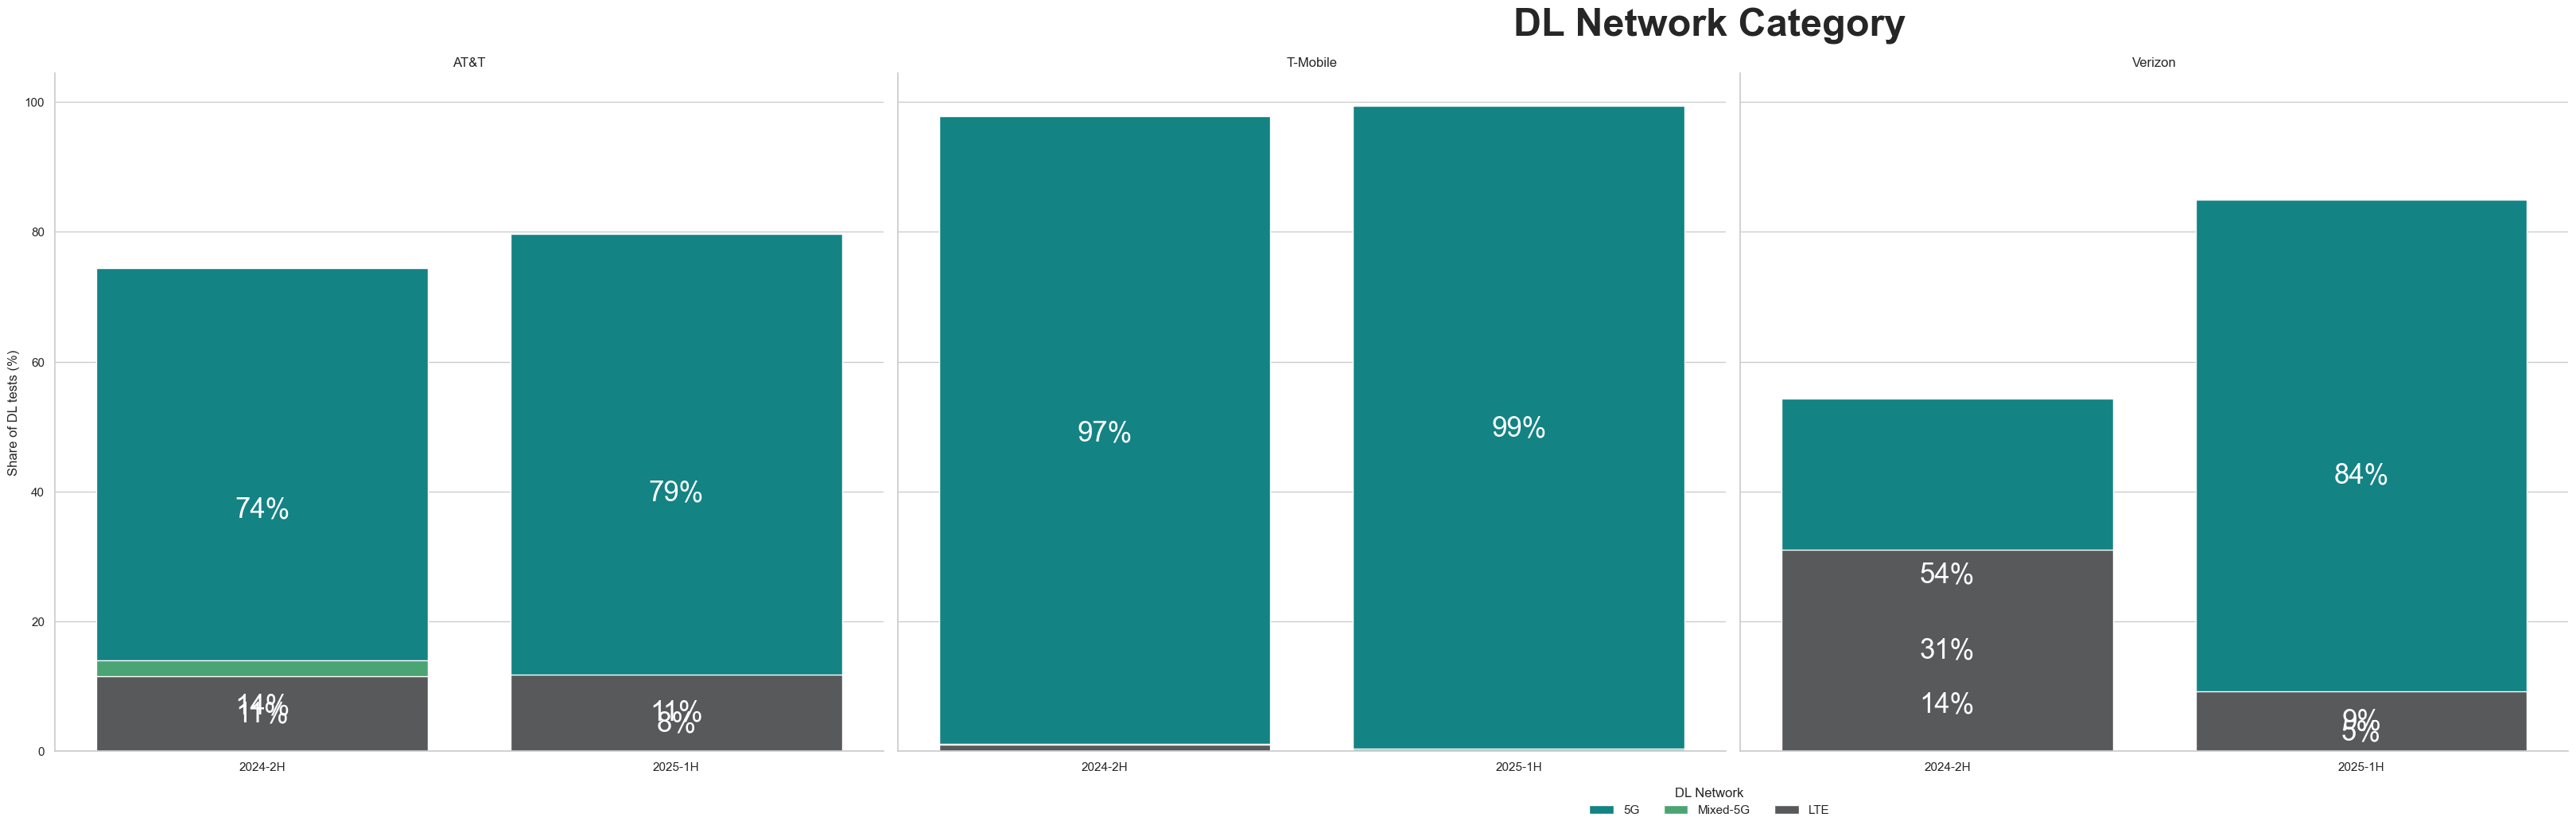

In [3727]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Add a column to distinguish between current and comparison data

df_dl_5g_curr["product_period"] = df_dl_5g_curr["product_period"]
df_dl_5g_comp["product_period"] = df_dl_5g_comp["product_period"]

# Combine the two DataFrames
df_dl_5g_combined = pd.concat([df_dl_5g_comp,df_dl_5g_curr], ignore_index=True)

# Create FacetGrid
g = sns.FacetGrid(df_dl_5g_combined, col="carrier", col_wrap=4, height=10, sharey=True)

# Map bar plots
g.map_dataframe(sns.barplot, x="product_period", y="dl_pct", hue="dl_network",
                palette=dl_color_dict, dodge=False, errorbar=None)

# Add text labels to bars (only for current data)
for ax, (_, subdata) in zip(g.axes.flat, df_dl_5g_curr.groupby("carrier")):
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height >= 3:
                ax.text(bar.get_x() + bar.get_width() / 2., height / 2,
                        f'{int(height)}%', ha='center', va='center', color='white', fontsize=25)

# Customize layout
g.set_axis_labels("", "Share of DL tests (%)")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("DL Network Category", fontsize=35, fontweight='bold')
g.add_legend(title="DL Network", bbox_to_anchor=(0.5, -0.05), loc='lower center', ncol=3)
plt.tight_layout()
plt.show()



# df_dl_5g_combined.head(len(df_dl_5g_combined))

Display table only for current:

In [3728]:
df_dl_5g_curr.head(len(df_dl_5g_curr))

,product_period,carrier,dl_network,count,dl_pct,access_spd,med_tput,max_tput,burst_tput,access,task
0,2025-1H,AT&T,5G,591,79.65,42.0,361.1,1039.5,1226.4,100.0,99.8
1,2025-1H,AT&T,Mixed-5G,63,8.49,45.0,94.8,619.2,926.1,99.7,96.3
2,2025-1H,AT&T,LTE,88,11.86,42.0,17.8,274.6,759.3,96.9,92.3
3,2025-1H,T-Mobile,5G,738,99.46,35.0,456.4,1471.9,1717.9,99.6,99.3
4,2025-1H,T-Mobile,Mixed-5G,3,0.40,42.0,12.6,60.9,164.2,100.0,96.3
5,2025-1H,T-Mobile,LTE,1,0.13,38.0,0.8,0.8,4.0,100.0,77.8
6,2025-1H,Verizon,5G,630,84.91,51.0,210.0,710.7,866.8,100.0,99.9
7,2025-1H,Verizon,Mixed-5G,43,5.80,52.0,84.3,237.1,464.1,100.0,96.4
8,2025-1H,Verizon,LTE,69,9.30,58.0,49.4,117.6,198.9,100.0,100.0


Current:

In [3729]:
network_category_curr = f'''
with best_network_type as (
  select pro.product_period, c.friendly_name as carrier,
  md2.fn_get_best_network_type(ts.test_type_id, ts.net_types, tea.network_types, tea.call_network_type, tea.nr_status_filtered, tea.nr_bearer_status_filtered,tea.nr_bearer_allocation_status_filtered,',') best_network_type
  from prod_rsr_partitions.test_event_aggr_{curr_csid} tea
  join prod_ms_partitions.test_summary_{curr_csid} ts using (test_event_id)
  join md2.carriers c on (c.carrier_id = ts.carrier_id)
  join md2.product_periods pro using(product_period_id)
  where c.friendly_name NOT IN ('Dish') AND  ts.blacklisted = false and ts.flag_valid = true and ts.collection_set_period_id is not null and ts.test_type_id in (20,19,26)
),
data_network_category as (
select product_period, carrier,
    case when best_network_type in ('NR SA','NR NSA') then '5G'
    when best_network_type in ('NR SA, LTE','NR NSA, LTE') then 'Mixed-5G'
      when best_network_type in ('LTE') then 'LTE'
    else 'Non-LTE' end as network
from best_network_type
)
select product_period, carrier, network, count(*) as count, round(100 * count(*) / sum(count(*)) over (partition by carrier),1) as percent
from data_network_category
group by product_period, carrier, network
order by carrier, case when network = '5G' then 1 when network = 'Mixed-5G' then 2 when network = 'LTE' then 3 when network = 'Non-LTE' then 4 end
'''

df_network_category_curr = pd.read_sql_query(network_category_curr, con=os.getenv('RSR_SVC_CONN'))
df_network_category_curr.head()

,product_period,carrier,network,count,percent
0,2025-1H,AT&T,5G,1311,59.1
1,2025-1H,AT&T,Mixed-5G,171,7.7
2,2025-1H,AT&T,LTE,738,33.2
3,2025-1H,T-Mobile,5G,2208,99.5
4,2025-1H,T-Mobile,Mixed-5G,8,0.4


Comparisson:

In [3730]:
network_category_comp = f'''
with best_network_type as (
  select pro.product_period, c.friendly_name as carrier,
  md2.fn_get_best_network_type(ts.test_type_id, ts.net_types, tea.network_types, tea.call_network_type, tea.nr_status_filtered, tea.nr_bearer_status_filtered,tea.nr_bearer_allocation_status_filtered,',') best_network_type
  from prod_rsr_partitions.test_event_aggr_{comp_csid} tea
  join prod_ms_partitions.test_summary_{comp_csid} ts using (test_event_id)
  join md2.carriers c on (c.carrier_id = ts.carrier_id)
  join md2.product_periods pro using(product_period_id)
  where c.friendly_name NOT IN ('Dish') AND  ts.blacklisted = false and ts.flag_valid = true and ts.collection_set_period_id is not null and ts.test_type_id in (20,19,26)
),
data_network_category as (
select product_period, carrier,
    case when best_network_type in ('NR SA','NR NSA') then '5G'
    when best_network_type in ('NR SA, LTE','NR NSA, LTE') then 'Mixed-5G'
      when best_network_type in ('LTE') then 'LTE'
    else 'Non-LTE' end as network
from best_network_type
)
select product_period, carrier, network, count(*) as count, round(100 * count(*) / sum(count(*)) over (partition by carrier),1) as percent
from data_network_category
group by product_period, carrier, network
order by carrier, case when network = '5G' then 1 when network = 'Mixed-5G' then 2 when network = 'LTE' then 3 when network = 'Non-LTE' then 4 end
'''
df_network_category_comp = pd.read_sql_query(network_category_comp, con=os.getenv('RSR_SVC_CONN'))
df_network_category_comp.head()

,product_period,carrier,network,count,percent
0,2024-2H,AT&T,5G,752,35.9
1,2024-2H,AT&T,Mixed-5G,207,9.9
2,2024-2H,AT&T,LTE,1138,54.3
3,2024-2H,T-Mobile,5G,2048,97.5
4,2024-2H,T-Mobile,Mixed-5G,35,1.7


Data Network Category filtered and reshape by network type

In [3731]:
# Combine the current and comparison DataFrames
df_network_category_combined = pd.concat([df_network_category_curr, df_network_category_comp], ignore_index=True)

# Reshape the DataFrame
df_network_category_reshaped = df_network_category_combined.pivot_table(
    index=["product_period", "carrier"], 
    columns="network", 
    values="percent"
).reset_index()

# Remove the column index name
df_network_category_reshaped.columns.name = None  

# Sort by 'carrier'
df_network_category_reshaped = df_network_category_reshaped.sort_values(by="carrier").reset_index(drop=True)

# Reorder  the columns
df_network_category_reshaped = df_network_category_reshaped[['product_period', 'carrier', '5G', 'Mixed-5G', 'LTE']]

# Display the entire DataFrame
df_network_category_reshaped.head(len(df_network_category_reshaped))

,product_period,carrier,5G,Mixed-5G,LTE
0,2024-2H,AT&T,35.9,9.9,54.3
1,2025-1H,AT&T,59.1,7.7,33.2
2,2024-2H,T-Mobile,97.5,1.7,0.9
3,2025-1H,T-Mobile,99.5,0.4,0.1
4,2024-2H,Verizon,37.2,15.4,47.4
5,2025-1H,Verizon,75.0,5.7,19.3


                                    Download Network Technology

In [3732]:
dl_lte_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]
dl_lte_curr['start_date'] = pd.to_datetime(dl_lte_curr['local_time']).dt.date

dl_lte_comp = df_ts_comp [df_ts_comp ['test_type_id'] == 20]
dl_lte_comp['start_date'] = pd.to_datetime(dl_lte_comp['local_time']).dt.date


filtered_net_type_curr = (
    dl_lte_curr['net_types'].isin([262144, 4194304, 4456448]) & 
    dl_lte_curr['net_types_desc'].isin(["LTE", "Mixed", "5G", "NR", "LTE,NR"]))
   
filtered_net_type_comp = (
    dl_lte_comp['net_types'].isin([262144, 4194304, 4456448]) & 
    dl_lte_comp['net_types_desc'].isin(["LTE", "Mixed", "5G", "NR", "LTE,NR"])
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1111104769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_lte_curr['start_date'] = pd.to_datetime(dl_lte_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1111104769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_lte_comp['start_date'] = pd.to_datetime(dl_lte_comp['local_time']).dt.date


                                            DL LTE market Daily

Current:

In [3733]:
lte_1 = (
    dl_lte_curr[filtered_net_type_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='lte_count') 
)

lte_2 = (
    dl_lte_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_curr = pd.merge(lte_1, lte_2, on=['carrier', 'start_date'], how='left').fillna(0)

lte_curr['lte_pct'] = round((lte_curr['lte_count'] / lte_curr['total_tests']) * 100, 2)

lte_curr.head()

,carrier,start_date,lte_count,total_tests,lte_pct
0,AT&T,2025-01-23,121,121,100.0
1,AT&T,2025-01-24,126,126,100.0
2,AT&T,2025-01-25,125,125,100.0
3,AT&T,2025-01-26,120,120,100.0
4,AT&T,2025-01-27,124,124,100.0


Comparison:

In [3734]:

lte_3 = (
    dl_lte_comp[filtered_net_type_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='lte_count') 
)

lte_4 = (
    dl_lte_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_comp = pd.merge(lte_3, lte_4, on=['carrier', 'start_date'], how='left').fillna(0)

lte_comp['lte_pct'] = round((lte_comp['lte_count'] / lte_comp['total_tests']) * 100, 2)

lte_comp.head()

,carrier,start_date,lte_count,total_tests,lte_pct
0,AT&T,2024-07-23,101,101,100.0
1,AT&T,2024-07-24,123,123,100.0
2,AT&T,2024-07-25,119,119,100.0
3,AT&T,2024-07-26,122,122,100.0
4,AT&T,2024-07-27,114,114,100.0


                                                DL LTE Overall

Current:

In [3735]:
lte_5 = (
    dl_lte_curr[filtered_net_type_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='lte_count')
)

lte_6 = (
    dl_lte_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_all_curr = pd.merge(lte_5, lte_6, on=['carrier'], how='left').fillna(0)

lte_all_curr['mean_LTE_curr'] = round((lte_all_curr['lte_count'] / lte_all_curr['total_tests']) * 100, 2)

lte_all_curr.head()

/Users/jennymassari/miniconda3/envs/analytics_base/lib/python3.11/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,carrier,lte_count,total_tests,mean_LTE_curr
0,AT&T,742,742,100.0
1,T-Mobile,742,742,100.0
2,Verizon,742,742,100.0


Comparison:

In [3736]:
lte_7 = (
    dl_lte_comp[filtered_net_type_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='lte_count')
)

lte_8 = (
    dl_lte_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_all_comp = pd.merge(lte_7, lte_8, on=['carrier'], how='left').fillna(0)

lte_all_comp['mean_LTE_comp'] = round((lte_all_comp['lte_count'] / lte_all_comp['total_tests']) * 100, 2)

lte_all_comp.head()

,carrier,lte_count,total_tests,mean_LTE_comp
0,AT&T,698,698,100.0
1,T-Mobile,701,701,100.0
2,Verizon,701,701,100.0


PLOT GRAPH

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2712021923.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


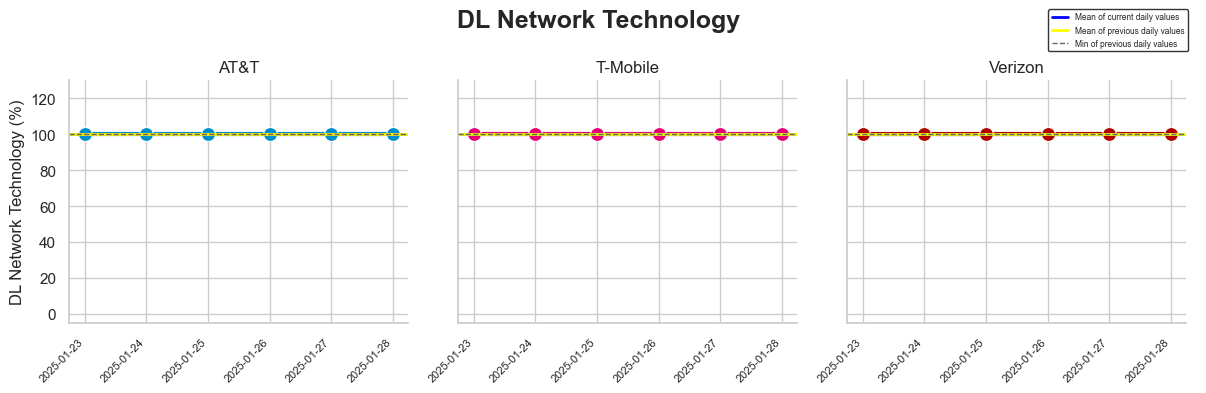

In [3737]:
def plot_with_summary(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily LTE percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="lte_pct",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = lte_all_curr[lte_all_curr['carrier'] == carrier]['mean_LTE_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = lte_all_comp[lte_all_comp['carrier'] == carrier]['mean_LTE_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = lte_comp[lte_comp['carrier'] == carrier]['lte_pct']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    lte_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_summary)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "DL Network Technology (%)")
g.set(ylim=(-5, 130))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("DL Network Technology", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()


Compute the EOM table

In [3738]:
#Merge and select columns
lte_rate = pd.merge(lte_all_curr, lte_all_comp, on='carrier', how='outer')
lte_rate = lte_rate.drop(columns=['lte_count_x', 'lte_count_y', 'total_tests_x', 'total_tests_y'])

#Delta
lte_rate['delta'] = (lte_rate['mean_LTE_curr'] - lte_rate['mean_LTE_comp'])

#Calculate percentage change
lte_rate['pct_change'] = round(((lte_rate['mean_LTE_curr'] - lte_rate['mean_LTE_comp']) / lte_rate['mean_LTE_comp']) * 100, 2)

#Add measure column
lte_rate['measure'] = 'DL Network Technology (%)'

#Reorder columns
lte_rate = lte_rate[['measure', 'carrier', 'mean_LTE_curr', 'mean_LTE_comp', 'delta', 'pct_change']]

#Rename columns
lte_rate = lte_rate.rename(columns={
    'mean_LTE_curr': 'current',
    'mean_LTE_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

#lte_rate.head()

                                                    M2M VoLTE/VoNR/EPS Fallback

In [3739]:
call_data_curr = df_ts_curr[df_ts_curr['test_type_id'] == 23]
call_data_curr['start_date'] = pd.to_datetime(call_data_curr['local_time']).dt.date

filtered_call_net_type_curr = (
    call_data_curr['call_network_type'].isin(["VoLTE", "EPS Fallback", "VoNR"]) 
)

call_data_comp = df_ts_comp[df_ts_comp['test_type_id'] == 23]
call_data_comp['start_date'] = pd.to_datetime(call_data_comp['local_time']).dt.date

filtered_call_net_type_comp = (
    call_data_comp['call_network_type'].isin(["VoLTE", "EPS Fallback", "VoNR"]) 
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1874461607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['start_date'] = pd.to_datetime(call_data_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1874461607.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_comp['start_date'] = pd.to_datetime(call_data_comp['local_time']).dt.date


In [3740]:
# call_data_curr.head()

Current VoLTE:

In [3741]:
volte_1 = (
    call_data_curr[filtered_call_net_type_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_2 = (
    call_data_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

volte_curr = pd.merge(volte_1, volte_2, on=['carrier', 'start_date'], how='left').fillna(0)

volte_curr['volte_pct'] = round((volte_curr['volte_count'] / volte_curr['total_tests']) * 100, 2)

volte_curr.head()

,carrier,start_date,volte_count,total_tests,volte_pct
0,AT&T,2025-01-23,107,107,100.0
1,AT&T,2025-01-24,108,108,100.0
2,AT&T,2025-01-25,105,105,100.0
3,AT&T,2025-01-26,102,102,100.0
4,AT&T,2025-01-27,107,107,100.0


Comparison VoLTE:

In [3742]:
volte_3 = (
    call_data_comp[filtered_call_net_type_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_4 = (
    call_data_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

volte_comp = pd.merge(volte_3, volte_4, on=['carrier', 'start_date'], how='left').fillna(0)

volte_comp['volte_pct'] = round((volte_comp['volte_count'] / volte_comp['total_tests']) * 100, 2)

volte_comp.head()

,carrier,start_date,volte_count,total_tests,volte_pct
0,AT&T,2024-07-23,90,90,100.0
1,AT&T,2024-07-24,110,110,100.0
2,AT&T,2024-07-25,106,106,100.0
3,AT&T,2024-07-26,109,109,100.0
4,AT&T,2024-07-27,104,104,100.0


                                                    DL LTE Overall

Current:

In [3743]:
volte_5 = (
    call_data_curr[filtered_call_net_type_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_6 = (
    call_data_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

volte_all_curr = pd.merge(volte_5, volte_6, on=['carrier'], how='left').fillna(0)

volte_all_curr['mean_voLTE_curr'] = round((volte_all_curr['volte_count'] / volte_all_curr['total_tests']) * 100, 2)

volte_all_curr.head()

,carrier,volte_count,total_tests,mean_voLTE_curr
0,AT&T,640,640,100.00
1,T-Mobile,638,640,99.69
2,Verizon,638,640,99.69


Comparison:

In [3744]:
volte_7 = (
    call_data_comp[filtered_call_net_type_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_8 = (
    call_data_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

volte_all_comp = pd.merge(volte_7, volte_8, on=['carrier'], how='left').fillna(0)

volte_all_comp['mean_voLTE_comp'] = round((volte_all_comp['volte_count'] / volte_all_comp['total_tests']) * 100, 2)

volte_all_comp.head()

,carrier,volte_count,total_tests,mean_voLTE_comp
0,AT&T,627,627,100.00
1,T-Mobile,626,628,99.68
2,Verizon,627,627,100.00


PLOT GRAPH

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/3295678291.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


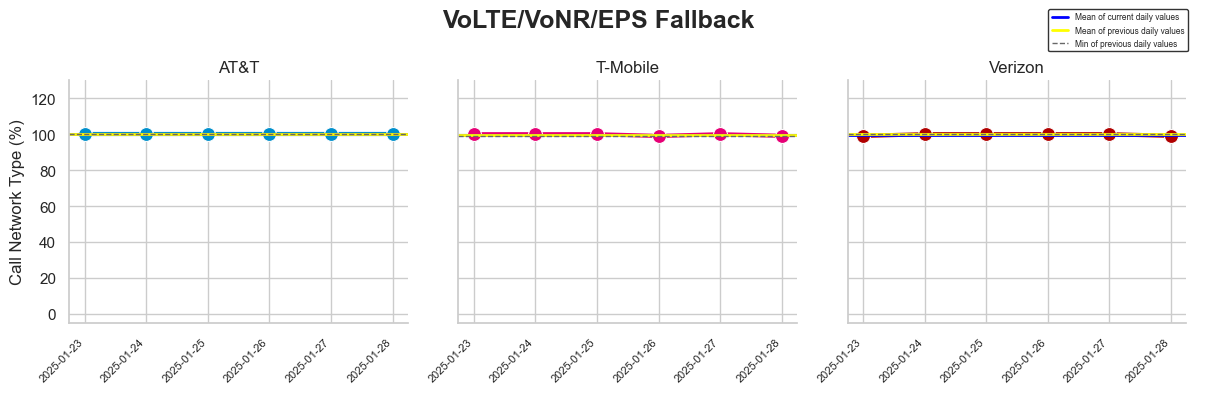

In [3745]:
def plot_with_fallback(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily LTE percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="volte_pct",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = volte_all_curr[volte_all_curr['carrier'] == carrier]['mean_voLTE_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = volte_all_comp[volte_all_comp['carrier'] == carrier]['mean_voLTE_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = volte_comp[volte_comp['carrier'] == carrier]['volte_pct']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    volte_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_fallback)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "Call Network Type (%)")
g.set(ylim=(-5, 130))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("VoLTE/VoNR/EPS Fallback", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()


compute the EOM table

In [3753]:
#Merge and select columns
volte_rate = pd.merge(volte_all_curr, volte_all_comp, on='carrier', how='outer')
volte_rate = volte_rate.drop(columns=['volte_count_x', 'volte_count_y', 'total_tests_x', 'total_tests_y'])

#Delta
volte_rate['delta'] = (volte_rate['mean_voLTE_curr'] - volte_rate['mean_voLTE_comp'])

#Calculate percentage change
volte_rate['pct_change'] = round(((volte_rate['mean_voLTE_curr'] - volte_rate['mean_voLTE_comp']) / volte_rate['mean_voLTE_comp']) * 100, 2)

#Add measure column
volte_rate['measure'] = 'Call Network Type (%)'

#Reorder columns
volte_rate = volte_rate[['measure', 'carrier', 'mean_voLTE_curr', 'mean_voLTE_comp', 'delta', 'pct_change']]

#Rename columns
volte_rate = volte_rate.rename(columns={
    'mean_LTE_curr': 'current',
    'mean_LTE_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

# volte_rate.head()

,measure,carrier,mean_voLTE_curr,mean_voLTE_comp,delta,% pct_change
0,Call Network Type (%),AT&T,100.00,100.00,0.00,0.00
1,Call Network Type (%),T-Mobile,99.69,99.68,0.01,0.01
2,Call Network Type (%),Verizon,99.69,100.00,-0.31,-0.31


                                Mobile-to-Mobile Call Block

In [ ]:
call_data_curr['blocked_call'] = 0
mask =(call_data_curr['flag_access_success'] == False)
call_data_curr.loc[mask, 'blocked_call'] = 1

filtered_call_block_curr = (
    call_data_curr['blocked_call'] == 1
)

call_data_comp['blocked_call'] = 0
mask =(call_data_comp['flag_access_success'] == False)
call_data_comp.loc[mask, 'blocked_call'] = 1

filtered_call_block_comp = (
    call_data_comp['blocked_call'] == 1
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2479447700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['blocked_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2479447700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_comp['blocked_call'] = 0


M2M Block Rate Current market Daily

In [ ]:
blk_1 = (
    call_data_curr[filtered_call_block_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_2 = (
    call_data_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_curr = pd.merge(blk_1, blk_2, on=['carrier', 'start_date'], how='right').fillna(0)

block_curr['block_pct'] = round((block_curr['block_count'] / block_curr['total_tests']) * 100, 2)

block_curr = block_curr[['carrier', 'start_date', 'block_count', 'total_tests', 'block_pct']]

block_curr.head(len(block_curr))

,carrier,start_date,block_count,total_tests,block_pct
0,AT&T,2025-01-23,0.0,107,0.00
1,AT&T,2025-01-24,0.0,108,0.00
2,AT&T,2025-01-25,1.0,105,0.95
3,AT&T,2025-01-26,0.0,102,0.00
4,AT&T,2025-01-27,0.0,107,0.00
5,AT&T,2025-01-28,0.0,111,0.00
6,T-Mobile,2025-01-23,0.0,107,0.00
7,T-Mobile,2025-01-24,0.0,108,0.00
8,T-Mobile,2025-01-25,0.0,105,0.00
9,T-Mobile,2025-01-26,1.0,102,0.98


M2M Block Rate Comparison market Daily

In [ ]:
blk_3 = (
    call_data_comp[filtered_call_block_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_4 = (
    call_data_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_comp = pd.merge(blk_3, blk_4, on=['carrier', 'start_date'], how='right').fillna(0)

block_comp['block_pct'] = round((block_comp['block_count'] / block_comp['total_tests']) * 100, 2)

block_comp = block_comp[['carrier', 'start_date', 'block_count', 'total_tests', 'block_pct']]

block_comp.head()

,carrier,start_date,block_count,total_tests,block_pct
0,AT&T,2024-07-23,0.0,90,0.00
1,AT&T,2024-07-24,2.0,110,1.82
2,AT&T,2024-07-25,1.0,106,0.94
3,AT&T,2024-07-26,1.0,109,0.92
4,AT&T,2024-07-27,0.0,104,0.00


                                                        M2M Block Rate Overall

Current:

In [ ]:
blk_5 = (
    call_data_curr[filtered_call_block_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_6 = (
    call_data_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_all_curr = pd.merge(blk_5, blk_6, on=['carrier'], how='right').fillna(0)

block_all_curr['block_rate_curr'] = round((block_all_curr['block_count'] / block_all_curr['total_tests']) * 100, 2)
# Reorder the columns
block_all_curr = block_all_curr[['carrier', 'block_count', 'total_tests', 'block_rate_curr']]
block_all_curr.head()

,carrier,block_count,total_tests,block_rate_curr
0,AT&T,1,640,0.16
1,T-Mobile,2,640,0.31
2,Verizon,3,640,0.47


Comparison:

In [ ]:
blk_7 = (
    call_data_comp[filtered_call_block_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_8 = (
    call_data_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_all_comp = pd.merge(blk_7, blk_8, on=['carrier'], how='right').fillna(0)

block_all_comp['block_rate_comp'] = round((block_all_comp['block_count'] / block_all_comp['total_tests']) * 100, 2)
# Reorder the columns
block_all_comp = block_all_comp[['carrier', 'block_count', 'total_tests', 'block_rate_comp']]

block_all_comp.head()

,carrier,block_count,total_tests,block_rate_comp
0,AT&T,4,627,0.64
1,T-Mobile,5,628,0.80
2,Verizon,1,627,0.16


PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/25164658.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


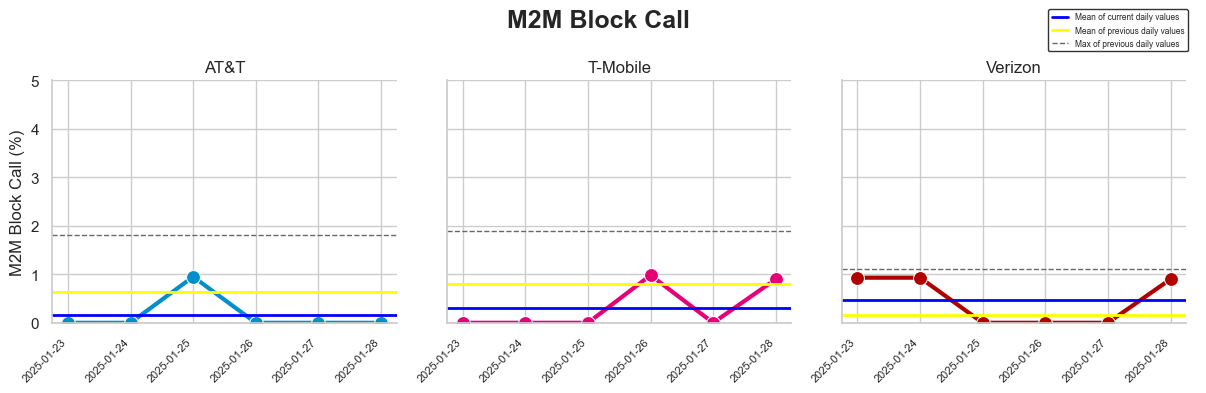

In [ ]:
def plot_with_call_block(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily block percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="block_pct",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = block_all_curr[block_all_curr['carrier'] == carrier]['block_rate_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = block_all_comp[block_all_comp['carrier'] == carrier]['block_rate_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    carrier_vals = block_comp[block_comp['carrier'] == carrier]['block_pct']
    if not carrier_vals.empty:
        max_val = carrier_vals.max()
        plt.axhline(
            y=max_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    block_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_call_block)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "M2M Block Call (%)")
g.set(ylim=(0, 5))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") 

plt.subplots_adjust(top=0.9)
g.fig.suptitle("M2M Block Call", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
max_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Max of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, max_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()


Compute EOM table

In [3756]:
#Merge and select columns
block_rate = pd.merge(block_all_curr, block_all_comp, on='carrier', how='outer')

block_rate = block_rate.drop(columns=['block_count_x', 'block_count_y', 'total_tests_x', 'total_tests_y'])

#Delta
block_rate['delta'] = (block_rate['block_rate_curr'] - block_rate['block_rate_comp'])

#Calculate percentage change
block_rate['pct_change'] = round(((block_rate['block_rate_curr'] - block_rate['block_rate_comp']) / block_rate['block_rate_comp']) * 100, 2)

#Add measure column
block_rate['measure'] = 'M2M Blocked Call (%)'

#Reorder columns
block_rate = block_rate[['measure', 'carrier', 'block_rate_curr', 'block_rate_comp', 'delta', 'pct_change']]

#Rename columns
block_rate = block_rate.rename(columns={
    'mean_LTE_curr': 'current',
    'mean_LTE_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

block_rate.head()

,measure,carrier,block_rate_curr,block_rate_comp,delta,% pct_change
0,M2M Blocked Call (%),AT&T,0.16,0.64,-0.48,-75.00
1,M2M Blocked Call (%),T-Mobile,0.31,0.80,-0.49,-61.25
2,M2M Blocked Call (%),Verizon,0.47,0.16,0.31,193.75


                                                Mobile-to-Mobile Call Drop

In [ ]:
call_data_curr['blocked_call'] = 0
mask =(call_data_curr['flag_access_success'] == False)
call_data_curr.loc[mask, 'blocked_call'] = 1

call_data_curr['dropped_call'] = 0
mask = (call_data_curr['flag_task_success'] == False)
call_data_curr.loc[mask, 'dropped_call'] = 1

call_data_curr['incomplete_call'] = 0
mask = (call_data_curr['flag_access_success'] == True) & \
       (call_data_curr['flag_task_success'] == None)
call_data_curr.loc[mask, 'incomplete_call'] = 1

# filter curr
filtered_call_drop_curr = (
    call_data_curr['dropped_call'] == 1
)

filtered_call_not_block_curr = (
    call_data_curr['blocked_call'] != 1
)

filtered_call_not_incomplete_curr = (
    call_data_curr['incomplete_call'] != 1
)

#comparison data

call_data_comp['blocked_call'] = 0
mask =(call_data_comp['flag_access_success'] == False)
call_data_comp.loc[mask, 'blocked_call'] = 1


call_data_comp['dropped_call'] = 0
mask = (call_data_comp['flag_task_success'] == False)
call_data_comp.loc[mask, 'dropped_call'] = 1

call_data_comp['incomplete_call'] = 0
mask = (call_data_comp['flag_access_success'] == True) & \
       (call_data_comp['flag_task_success'] == None)
call_data_comp.loc[mask, 'incomplete_call'] = 1

# filter comp
filtered_call_drop_comp = (
    call_data_comp['dropped_call'] == 1
)

filtered_call_not_block_comp = (
    call_data_comp['blocked_call'] != 1
)

filtered_call_not_incomplete_comp = (
    call_data_comp['incomplete_call'] != 1
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/338905326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['blocked_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/338905326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['dropped_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/338905326.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Current:

In [ ]:
drop_1 = (
    call_data_curr[filtered_call_drop_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_2 = (
    call_data_curr[filtered_call_not_block_curr & filtered_call_not_incomplete_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_curr = pd.merge(drop_1, drop_2, on=['carrier', 'start_date'], how='right').fillna(0)

drop_curr['drop_pct'] = round((drop_curr['drop_count'] / drop_curr['total_tests']) * 100, 2)

drop_curr = drop_curr[['carrier', 'start_date', 'drop_count', 'total_tests', 'drop_pct']]

drop_curr.head()

,carrier,start_date,drop_count,total_tests,drop_pct
0,AT&T,2025-01-23,0.0,107,0.0
1,AT&T,2025-01-24,0.0,108,0.0
2,AT&T,2025-01-25,0.0,104,0.0
3,AT&T,2025-01-26,0.0,102,0.0
4,AT&T,2025-01-27,0.0,107,0.0


Comparison:

In [ ]:
drop_3 = (
    call_data_comp[filtered_call_drop_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_4 = (
    call_data_comp[filtered_call_not_block_comp & filtered_call_not_incomplete_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_comp = pd.merge(drop_3, drop_4, on=['carrier', 'start_date'], how='right').fillna(0)

drop_comp['drop_pct'] = round((drop_comp['drop_count'] / drop_comp['total_tests']) * 100, 2)

drop_comp = drop_comp[['carrier', 'start_date', 'drop_count', 'total_tests', 'drop_pct']]

drop_comp.head()

,carrier,start_date,drop_count,total_tests,drop_pct
0,AT&T,2024-07-23,0.0,90,0.0
1,AT&T,2024-07-24,0.0,108,0.0
2,AT&T,2024-07-25,0.0,105,0.0
3,AT&T,2024-07-26,0.0,108,0.0
4,AT&T,2024-07-27,0.0,104,0.0


                                                        M2M drop Rate Comparison market Overall

Current:

In [ ]:
drop_5 = (
    call_data_curr[filtered_call_drop_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_6 = (
    call_data_curr[filtered_call_not_block_curr & filtered_call_not_incomplete_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_all_curr = pd.merge(drop_5, drop_6, on=['carrier'], how='right').fillna(0)

drop_all_curr['drop_rate_curr'] = round((drop_all_curr['drop_count'] / drop_all_curr['total_tests']) * 100, 2)

# Reorder the columns
drop_all_curr = drop_all_curr[['carrier', 'drop_count', 'total_tests', 'drop_rate_curr']]

drop_all_curr.head()

,carrier,drop_count,total_tests,drop_rate_curr
0,AT&T,0.0,639,0.00
1,T-Mobile,2.0,638,0.31
2,Verizon,1.0,637,0.16


Comparison

In [ ]:
drop_7 = (
    call_data_comp[filtered_call_drop_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_8 = (
    call_data_comp[filtered_call_not_block_comp & filtered_call_not_incomplete_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_all_comp = pd.merge(drop_7, drop_8, on=['carrier'], how='right').fillna(0)

drop_all_comp['drop_rate_comp'] = round((drop_all_comp['drop_count'] / drop_all_comp['total_tests']) * 100, 2)

# Reorder the columns
drop_all_comp = drop_all_comp[['carrier', 'drop_count', 'total_tests', 'drop_rate_comp']]

drop_all_comp.head()

,carrier,drop_count,total_tests,drop_rate_comp
0,AT&T,0.0,623,0.00
1,T-Mobile,3.0,623,0.48
2,Verizon,1.0,626,0.16


PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2070678131.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


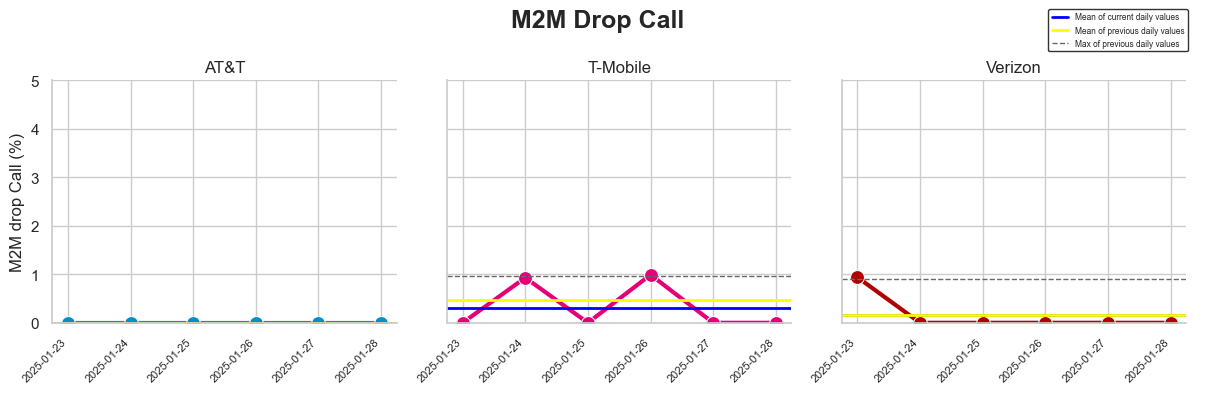

In [ ]:
def plot_with_call_drop(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily drop percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="drop_pct",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = drop_all_curr[drop_all_curr['carrier'] == carrier]['drop_rate_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = drop_all_comp[drop_all_comp['carrier'] == carrier]['drop_rate_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    carrier_vals = drop_comp[drop_comp['carrier'] == carrier]['drop_pct']
    if not carrier_vals.empty:
        max_val = carrier_vals.max()
        plt.axhline(
            y=max_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    drop_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_call_drop)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "M2M drop Call (%)")
g.set(ylim=(0, 5))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") 

plt.subplots_adjust(top=0.9)
g.fig.suptitle("M2M Drop Call", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
max_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Max of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, max_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()


Compute EOM table

In [3757]:
#Merge and select columns
drop_rate = pd.merge(drop_all_curr, drop_all_comp, on='carrier', how='outer')

drop_rate = drop_rate.drop(columns=['drop_count_x', 'drop_count_y', 'total_tests_x', 'total_tests_y'])

#Delta
drop_rate['delta'] = (drop_rate['drop_rate_curr'] - drop_rate['drop_rate_comp'])

#Calculate percentage change
drop_rate['pct_change'] = round(((drop_rate['drop_rate_curr'] - drop_rate['drop_rate_comp']) / drop_rate['drop_rate_comp']) * 100, 2)

#Add measure column
drop_rate['measure'] = 'M2M Droped Call (%)'

#Reorder columns
drop_rate = drop_rate[['measure', 'carrier', 'drop_rate_curr', 'drop_rate_comp', 'delta', 'pct_change']]

#Rename columns
drop_rate = drop_rate.rename(columns={
    'mean_LTE_curr': 'current',
    'mean_LTE_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

drop_rate.head()

,measure,carrier,drop_rate_curr,drop_rate_comp,delta,% pct_change
0,M2M Droped Call (%),AT&T,0.00,0.00,0.00,NaN
1,M2M Droped Call (%),T-Mobile,0.31,0.48,-0.17,-35.42
2,M2M Droped Call (%),Verizon,0.16,0.16,0.00,0.00


                                            Download Throughput

In [ ]:
##Current
# Filter rows
filtered_dl_tput_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]

# Convert to date
filtered_dl_tput_curr['start_date'] = pd.to_datetime(filtered_dl_tput_curr['local_time']).dt.date

# Convert download speed to Mbps (kbit/s ÷ 1000)
filtered_dl_tput_curr['download_mbps'] = filtered_dl_tput_curr['dsd_effective_download_test_speed'] / 1000

##Comparison:
# Filter rows
filtered_dl_tput_comp = df_ts_comp[df_ts_comp['test_type_id'] == 20]

# Convert to date
filtered_dl_tput_comp['start_date'] = pd.to_datetime(filtered_dl_tput_comp['local_time']).dt.date

# Convert download speed to Mbps (kbit/s ÷ 1000)
filtered_dl_tput_comp['download_mbps'] = filtered_dl_tput_comp['dsd_effective_download_test_speed'] / 1000

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1413940453.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_tput_curr['start_date'] = pd.to_datetime(filtered_dl_tput_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1413940453.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_tput_curr['download_mbps'] = filtered_dl_tput_curr['dsd_effective_download_test_speed'] / 1000
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ip

Current:

In [ ]:
dl_tput_curr = (
    filtered_dl_tput_curr
    .groupby(['carrier', 'start_date'], as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'median_dl_tput_curr'})
)

dl_tput_curr['median_dl_tput_curr'] = dl_tput_curr['median_dl_tput_curr'].round(2)

dl_tput_curr.head()

,carrier,start_date,median_dl_tput_curr
0,AT&T,2025-01-23,313.94
1,AT&T,2025-01-24,209.79
2,AT&T,2025-01-25,285.64
3,AT&T,2025-01-26,365.37
4,AT&T,2025-01-27,327.55


Comparison:

In [ ]:
dl_tput_comp = (
    filtered_dl_tput_comp
    .groupby(['carrier', 'start_date'], as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'median_dl_tput_comp'})
)

dl_tput_comp['median_dl_tput_comp'] = dl_tput_comp['median_dl_tput_comp'].round(2)

dl_tput_comp.head()

,carrier,start_date,median_dl_tput_comp
0,AT&T,2024-07-23,320.98
1,AT&T,2024-07-24,294.89
2,AT&T,2024-07-25,266.68
3,AT&T,2024-07-26,305.57
4,AT&T,2024-07-27,266.93


Current:

In [ ]:
dl_tput_all_curr = (
    filtered_dl_tput_curr
    .groupby('carrier', as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'dl_tput_curr_line'})
)

dl_tput_all_curr['dl_tput_curr_line'] = dl_tput_all_curr['dl_tput_curr_line'].round(2)

dl_tput_all_curr.head()

,carrier,dl_tput_curr_line
0,AT&T,297.63
1,T-Mobile,454.96
2,Verizon,197.50


Comparison:

In [ ]:
dl_tput_all_comp = (
    filtered_dl_tput_comp
    .groupby('carrier', as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'dl_tput_comp_line'})
)

dl_tput_all_comp['dl_tput_comp_line'] = dl_tput_all_comp['dl_tput_comp_line'].round(2)

dl_tput_all_comp.head()

,carrier,dl_tput_comp_line
0,AT&T,296.04
1,T-Mobile,422.64
2,Verizon,119.54


PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1901210197.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


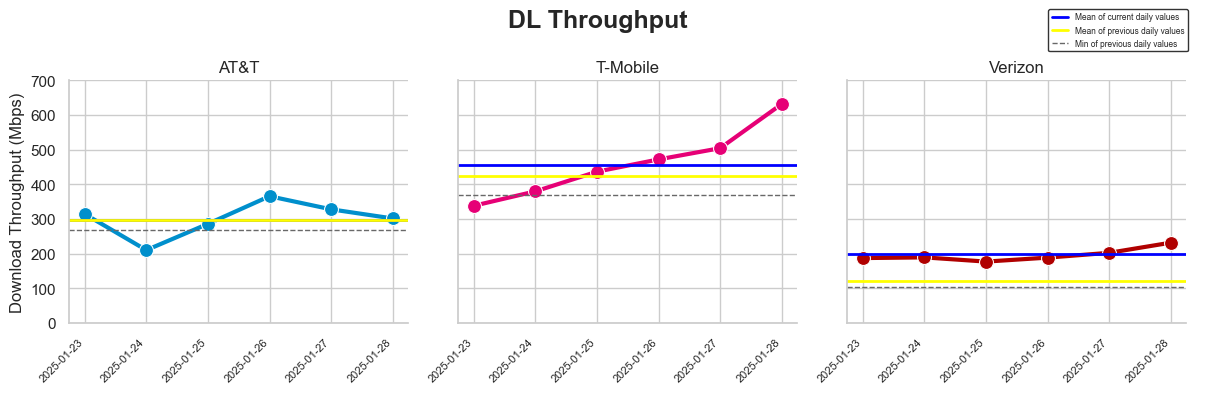

In [ ]:
def plot_with_dl_tput(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily DL percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="median_dl_tput_curr",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = dl_tput_all_curr[dl_tput_all_curr['carrier'] == carrier]['dl_tput_curr_line']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = dl_tput_all_comp[dl_tput_all_comp['carrier'] == carrier]['dl_tput_comp_line']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = dl_tput_comp[dl_tput_comp['carrier'] == carrier]['median_dl_tput_comp']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    dl_tput_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_dl_tput)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "Download Throughput (Mbps)")
g.set(ylim=(0, 700))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("DL Throughput", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()

compute EOM table

In [3765]:
#Merge and select columns
dl_tput = pd.merge(dl_tput_all_curr, dl_tput_all_comp, on='carrier', how='outer')


#Delta
dl_tput['delta'] = (dl_tput['dl_tput_curr_line'] - dl_tput['dl_tput_comp_line'])

#Calculate percentage change
dl_tput['pct_change'] = round(((dl_tput['dl_tput_curr_line'] - dl_tput['dl_tput_comp_line']) / dl_tput['dl_tput_comp_line']) * 100, 2)

# #Add measure column
dl_tput['measure'] = 'DL Throughput (Mbps)'

#Reorder columns
dl_tput = dl_tput[['measure', 'carrier', 'dl_tput_curr_line', 'dl_tput_comp_line', 'delta', 'pct_change']]

#Rename columns
dl_tput = dl_tput.rename(columns={
    'dl_tput_curr_line': 'current',
    'dl_tput_comp_line': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

dl_tput.head()

,measure,carrier,current,comparison,delta,% pct_change
0,DL Throughput (Mbps),AT&T,297.63,296.04,1.59,0.54
1,DL Throughput (Mbps),T-Mobile,454.96,422.64,32.32,7.65
2,DL Throughput (Mbps),Verizon,197.50,119.54,77.96,65.22


                                                    Upload Throughput

In [ ]:
filtered_ul_tput_curr = df_ts_curr[df_ts_curr['test_type_id'] == 19]
filtered_ul_tput_curr['start_date'] = pd.to_datetime(filtered_ul_tput_curr['local_time']).dt.date
filtered_ul_tput_curr['upload_mbps'] = filtered_ul_tput_curr['dsu_effective_upload_test_speed'] / 1000

filtered_ul_tput_comp = df_ts_comp[df_ts_comp['test_type_id'] == 19]
filtered_ul_tput_comp['start_date'] = pd.to_datetime(filtered_ul_tput_comp['local_time']).dt.date
filtered_ul_tput_comp['upload_mbps'] = filtered_ul_tput_comp['dsu_effective_upload_test_speed'] / 1000

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2908335583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ul_tput_curr['start_date'] = pd.to_datetime(filtered_ul_tput_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2908335583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ul_tput_curr['upload_mbps'] = filtered_ul_tput_curr['dsu_effective_upload_test_speed'] / 1000
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipyker

Current:

In [ ]:
ul_tput_curr = (
    filtered_ul_tput_curr
    .groupby(['carrier', 'start_date'], as_index=False)['upload_mbps']
    .median()
    .rename(columns={'upload_mbps': 'median_ul_tput_curr'})
)
ul_tput_curr['median_ul_tput_curr'] = ul_tput_curr['median_ul_tput_curr'].round(2)

ul_tput_curr.head()

,carrier,start_date,median_ul_tput_curr
0,AT&T,2025-01-23,24.53
1,AT&T,2025-01-24,35.24
2,AT&T,2025-01-25,28.75
3,AT&T,2025-01-26,33.79
4,AT&T,2025-01-27,35.33


Comparison:

In [ ]:
ul_tput_comp = (
    filtered_ul_tput_comp
    .groupby(['carrier', 'start_date'], as_index=False)['upload_mbps']
    .median()
    .rename(columns={'upload_mbps': 'median_ul_tput_comp'})
)
ul_tput_comp['median_ul_tput_comp'] = ul_tput_comp['median_ul_tput_comp'].round(2)

ul_tput_comp.head()

,carrier,start_date,median_ul_tput_comp
0,AT&T,2024-07-23,18.09
1,AT&T,2024-07-24,13.12
2,AT&T,2024-07-25,17.28
3,AT&T,2024-07-26,11.81
4,AT&T,2024-07-27,11.60


                                                    ALL

Current:

In [ ]:
ul_tput_all_curr = (
    filtered_ul_tput_curr
    .groupby('carrier', as_index=False)['upload_mbps']
    .median()
    .rename(columns={'upload_mbps': 'ul_tput_curr_line'})
)
ul_tput_all_curr['ul_tput_curr_line'] = ul_tput_all_curr['ul_tput_curr_line'].round(2)

ul_tput_all_curr.head()

,carrier,ul_tput_curr_line
0,AT&T,32.04
1,T-Mobile,45.35
2,Verizon,25.97


Comparison:

In [ ]:
ul_tput_all_comp = (
    filtered_ul_tput_comp
    .groupby('carrier', as_index=False)['upload_mbps']
    .median()
    .rename(columns={'upload_mbps': 'ul_tput_comp_line'})
)
ul_tput_all_comp['ul_tput_comp_line'] = ul_tput_all_comp['ul_tput_comp_line'].round(2)

ul_tput_all_comp.head()

,carrier,ul_tput_comp_line
0,AT&T,13.76
1,T-Mobile,43.50
2,Verizon,18.65


PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/4098718903.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


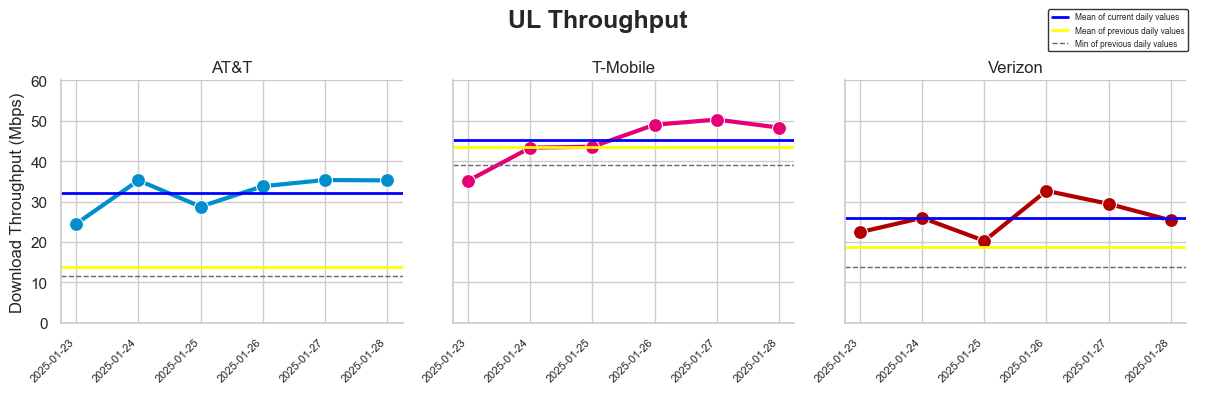

In [ ]:
def plot_with_ul_tput(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily ul percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="median_ul_tput_curr",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = ul_tput_all_curr[ul_tput_all_curr['carrier'] == carrier]['ul_tput_curr_line']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = ul_tput_all_comp[ul_tput_all_comp['carrier'] == carrier]['ul_tput_comp_line']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = ul_tput_comp[ul_tput_comp['carrier'] == carrier]['median_ul_tput_comp']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    ul_tput_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_ul_tput)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "Download Throughput (Mbps)")
g.set(ylim=(0, 60))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("UL Throughput", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()

compute EOM table

In [3767]:
#Merge and select columns
ul_tput = pd.merge(ul_tput_all_curr, ul_tput_all_comp, on='carrier', how='outer')

#Delta
ul_tput['delta'] = (ul_tput['ul_tput_curr_line'] - ul_tput['ul_tput_comp_line'])

#Calculate percentage change
ul_tput['pct_change'] = round(((ul_tput['ul_tput_curr_line'] - ul_tput['ul_tput_comp_line']) / ul_tput['ul_tput_comp_line']) * 100, 2)

# #Add measure column
ul_tput['measure'] = 'UL Throughput (Mbps)'

#Reorder columns
ul_tput = ul_tput[['measure', 'carrier', 'ul_tput_curr_line', 'ul_tput_comp_line', 'delta', 'pct_change']]

#Rename columns
ul_tput = ul_tput.rename(columns={
    'ul_tput_curr_line': 'current',
    'ul_tput_comp_line': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

ul_tput.head()

,measure,carrier,current,comparison,delta,% pct_change
0,UL Throughput (Mbps),AT&T,32.04,13.76,18.28,132.85
1,UL Throughput (Mbps),T-Mobile,45.35,43.50,1.85,4.25
2,UL Throughput (Mbps),Verizon,25.97,18.65,7.32,39.25


                                                Download Access Success

In [ ]:
filtered_dl_acc_succ_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]
filtered_dl_acc_succ_curr['start_date'] = pd.to_datetime(filtered_dl_acc_succ_curr['local_time']).dt.date
filtered_dl_acc_succ_curr['percentage_access_success'] = filtered_dl_acc_succ_curr['percentage_access_success'] * 100


filtered_dl_acc_succ_comp = df_ts_comp[df_ts_comp['test_type_id'] == 20]
filtered_dl_acc_succ_comp['start_date'] = pd.to_datetime(filtered_dl_acc_succ_comp['local_time']).dt.date
filtered_dl_acc_succ_comp['percentage_access_success'] = filtered_dl_acc_succ_comp['percentage_access_success'] * 100

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/3522016850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_acc_succ_curr['start_date'] = pd.to_datetime(filtered_dl_acc_succ_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/3522016850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_acc_succ_curr['percentage_access_success'] = filtered_dl_acc_succ_curr['percentage_access_success'] * 100
/var/folders/bp/rq20yws14k3dmzd9

In [ ]:
dl_acc_curr = (
    filtered_dl_acc_succ_curr
    .groupby(['carrier', 'start_date'], as_index=False)['percentage_access_success']
    .mean()
    .rename(columns={'percentage_access_success': 'avg_dl_acc'})
)

dl_acc_curr['avg_dl_acc'] = dl_acc_curr['avg_dl_acc'].round(2)

dl_acc_curr.head()

,carrier,start_date,avg_dl_acc
0,AT&T,2025-01-23,100.00
1,AT&T,2025-01-24,99.52
2,AT&T,2025-01-25,99.15
3,AT&T,2025-01-26,99.83
4,AT&T,2025-01-27,99.68


ul_tput_curr<- as.data.frame (ts_curr %>% 
                                filter(test_type_id==19) %>% 
                                group_by(carrier, start_date = as.Date(format(local_time,"%Y-%m-%d"))) %>%
                                summarise(median_ul_tput_curr = round(median(dsu_effective_upload_test_speed, na.rm = TRUE)/1000,digits = 2)))

In [ ]:
dl_acc_comp = (
    filtered_dl_acc_succ_comp
    .groupby(['carrier', 'start_date'], as_index=False)['percentage_access_success']
    .mean()
    .rename(columns={'percentage_access_success': 'avg_dl_acc'})
)

dl_acc_comp['avg_dl_acc'] = dl_acc_comp['avg_dl_acc'].round(2)

dl_acc_comp.head()

,carrier,start_date,avg_dl_acc
0,AT&T,2024-07-23,99.60
1,AT&T,2024-07-24,99.61
2,AT&T,2024-07-25,99.72
3,AT&T,2024-07-26,99.51
4,AT&T,2024-07-27,100.00


                                                                ALL

Current:

In [ ]:
dl_all_acc_curr = (
    filtered_dl_acc_succ_curr
    .groupby('carrier', as_index=False)['percentage_access_success']
    .mean()
    .rename(columns={'percentage_access_success': 'avg_dl_acc_curr'})
)

dl_all_acc_curr['avg_dl_acc_curr'] = dl_all_acc_curr['avg_dl_acc_curr'].round(2)

dl_all_acc_curr.head()

,carrier,avg_dl_acc_curr
0,AT&T,99.6
1,T-Mobile,99.6
2,Verizon,100.0


Comparison:

In [ ]:
dl_all_acc_comp = (
    filtered_dl_acc_succ_comp
    .groupby('carrier', as_index=False)['percentage_access_success']
    .mean()
    .rename(columns={'percentage_access_success': 'avg_dl_acc_comp'})
)

dl_all_acc_comp['avg_dl_acc_comp'] = dl_all_acc_comp['avg_dl_acc_comp'].round(2)

dl_all_acc_comp.head()

,carrier,avg_dl_acc_comp
0,AT&T,99.74
1,T-Mobile,99.81
2,Verizon,100.00


PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/4153964406.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


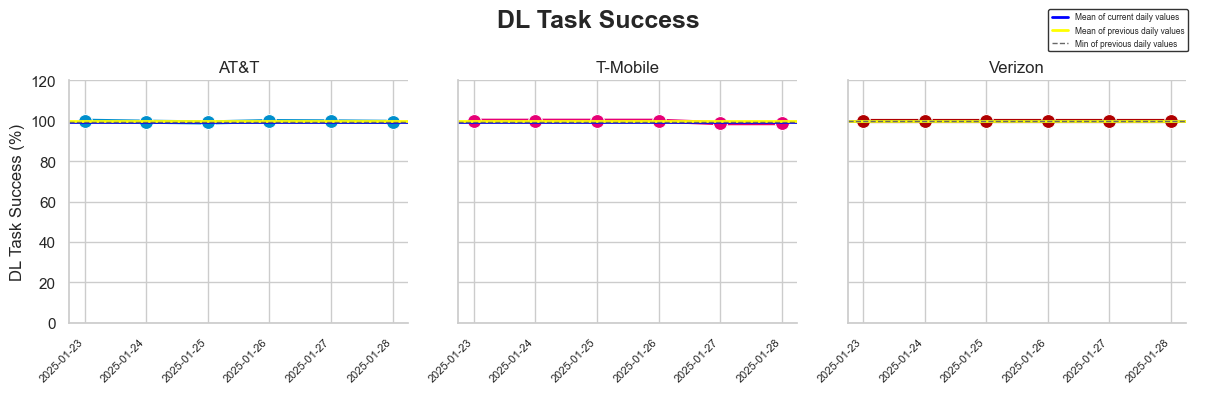

In [ ]:
def plot_with_dl_acc_succ(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily dl access success
    sns.lineplot(
        data=data,
        x="start_date",
        y="avg_dl_acc",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = dl_all_acc_curr[dl_all_acc_curr['carrier'] == carrier]['avg_dl_acc_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = dl_all_acc_comp[dl_all_acc_comp['carrier'] == carrier]['avg_dl_acc_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = dl_acc_comp[dl_acc_comp['carrier'] == carrier]['avg_dl_acc']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    dl_acc_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_dl_acc_succ)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "DL Task Success (%)")
g.set(ylim=(0, 120))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("DL Task Success", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()

                                                Download Task Success

In [ ]:
filtered_dl_task_succ_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]
filtered_dl_task_succ_curr['start_date'] = pd.to_datetime(filtered_dl_task_succ_curr['local_time']).dt.date
filtered_dl_task_succ_curr['percentage_task_success'] = filtered_dl_task_succ_curr['percentage_task_success'] * 100


filtered_dl_task_succ_comp = df_ts_comp[df_ts_comp['test_type_id'] == 20]
filtered_dl_task_succ_comp['start_date'] = pd.to_datetime(filtered_dl_task_succ_comp['local_time']).dt.date
filtered_dl_task_succ_comp['percentage_task_success'] = filtered_dl_task_succ_comp['percentage_task_success'] * 100

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2313656264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_task_succ_curr['start_date'] = pd.to_datetime(filtered_dl_task_succ_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2313656264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_task_succ_curr['percentage_task_success'] = filtered_dl_task_succ_curr['percentage_task_success'] * 100
/var/folders/bp/rq20yws14k3dmzd9

In [ ]:
dl_task_curr = (
    filtered_dl_task_succ_curr
    .groupby(['carrier', 'start_date'], as_index=False)['percentage_task_success']
    .mean()
    .rename(columns={'percentage_task_success': 'avg_dl_task'})
)

dl_task_curr['avg_dl_task'] = dl_task_curr['avg_dl_task'].round(2)

dl_task_curr.head()

,carrier,start_date,avg_dl_task
0,AT&T,2025-01-23,99.17
1,AT&T,2025-01-24,98.06
2,AT&T,2025-01-25,98.40
3,AT&T,2025-01-26,98.89
4,AT&T,2025-01-27,99.10


In [ ]:
dl_task_comp = (
    filtered_dl_task_succ_comp
    .groupby(['carrier', 'start_date'], as_index=False)['percentage_task_success']
    .mean()
    .rename(columns={'percentage_task_success': 'avg_dl_task'})
)

dl_task_comp['avg_dl_task'] = dl_task_comp['avg_dl_task'].round(2)

dl_task_comp.head()

,carrier,start_date,avg_dl_task
0,AT&T,2024-07-23,98.24
1,AT&T,2024-07-24,98.74
2,AT&T,2024-07-25,98.97
3,AT&T,2024-07-26,99.09
4,AT&T,2024-07-27,98.83


                                                                ALL

In [ ]:
dl_all_task_curr = (
    filtered_dl_task_succ_curr
    .groupby('carrier', as_index=False)['percentage_task_success']
    .mean()
    .rename(columns={'percentage_task_success': 'avg_dl_task_curr'})
)

dl_all_task_curr['avg_dl_task_curr'] = dl_all_task_curr['avg_dl_task_curr'].round(2)

dl_all_task_curr.head()

,carrier,avg_dl_task_curr
0,AT&T,98.61
1,T-Mobile,99.23
2,Verizon,99.75


In [ ]:
dl_all_task_comp = (
    filtered_dl_task_succ_comp
    .groupby('carrier', as_index=False)['percentage_task_success']
    .mean()
    .rename(columns={'percentage_task_success': 'avg_dl_task_comp'})
)

dl_all_task_comp['avg_dl_task_comp'] = dl_all_task_comp['avg_dl_task_comp'].round(2)

dl_all_task_comp.head()

,carrier,avg_dl_task_comp
0,AT&T,98.93
1,T-Mobile,99.71
2,Verizon,99.83


PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2740757891.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


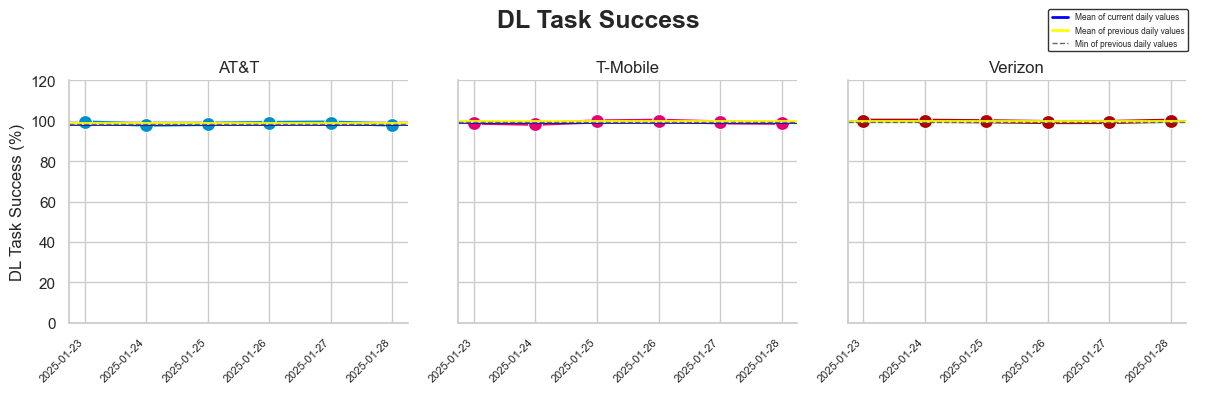

In [ ]:
def plot_with_dl_task_succ(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily dl task success
    sns.lineplot(
        data=data,
        x="start_date",
        y="avg_dl_task",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = dl_all_task_curr[dl_all_task_curr['carrier'] == carrier]['avg_dl_task_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = dl_all_task_comp[dl_all_task_comp['carrier'] == carrier]['avg_dl_task_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = dl_task_comp[dl_task_comp['carrier'] == carrier]['avg_dl_task']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    dl_task_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_dl_task_succ)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "DL Task Success (%)")
g.set(ylim=(0, 120))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("DL Task Success", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()